In [1]:
# Feature extraction for sound analysis of birdsong
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

from scipy.io import wavfile
import scipy.signal as signal
import IPython.display as ipd

In [ ]:
sound_file = 'Data/2023_03_31_7_03_30.wav'
fs, audio = wavfile.read(sound_file)
t_audio = np.linspace(0, len(audio)/fs, num=len(audio))

# Bandpass filter the audio signal
nyq = 0.5 * fs
low = 300 / nyq
high = 20000 / nyq
order = 5
b, a = signal.butter(order, [low, high], btype='band')

audio_clip = audio
t_audio_clip = np.linspace(0, 5, num=len(audio_clip))
ipd.Audio(sound_file)

In [6]:
from scipy.fft import fft, ifft, fftfreq, fftshift
window_length = 1323
hop_length = 163

def calculate_features(x, window_length, hop_length, fs, num_tapers=2):
    tapers = signal.windows.dpss(window_length, 1.5, 2)
    size = len(x)
    f_notShifted = fftfreq(window_length, 1/fs)
    f = fftshift(f_notShifted)
    f_index = f > 0

    sonogram = np.zeros((f_index.sum(), np.floor(size / hop_length).astype(int)))
    freq_deriv = np.zeros((f_index.sum(), np.floor(size / hop_length).astype(int)))
    time_deriv = np.zeros((f_index.sum(), np.floor(size / hop_length).astype(int)))

    goodness_of_fit = np.zeros(np.floor(size / hop_length).astype(int))
    frequency_modulation = np.zeros(np.floor(size / hop_length).astype(int))
    spectral_derivative = np.zeros((f_index.sum(), np.floor(size / hop_length).astype(int)))
    entropy = np.zeros(np.floor(size / hop_length).astype(int))
    amplitude = np.zeros(np.floor(size / hop_length).astype(int))

    wav_smp = np.arange(size-window_length, step=hop_length).astype(int)
    t = np.arange(np.floor(size / hop_length)) *(hop_length/fs)

    for i in range(len(wav_smp)):
        samps = np.arange(wav_smp[i], np.floor(wav_smp[i] + window_length).astype(int))
        window1 = x[samps] * tapers[0]
        window2 = x[samps] * tapers[1]

        # If the window has values, calculate the cepstrum
        if(window1.any()):
            real_cepstrum = fftshift(np.real(ifft(np.log10(fft(window1)))))
            goodness_of_fit[i] = np.max(real_cepstrum[f_index])
        else:
            goodness_of_fit[i] = 0
        
        powSpect1 = fftshift(fft(window1))
        powSpect2 = fftshift(fft(window2))

        r1 = (np.abs(powSpect1) + np.abs(powSpect2))**2
        sonogram[:,i] = r1[f_index]

        # Getting time and frequency derivatives
        fR1 = np.real(powSpect1[f_index])
        fi1 = np.imag(powSpect1[f_index])
        fR2 = np.real(powSpect2[f_index])
        fi2 = np.imag(powSpect2[f_index])

        time_deriv[:,i] = -fR1*fR2 - fi1*fi2
        freq_deriv[:,i] = fi1*fR2 - fR1*fi2

        # Getting frequnecy modulation
        frequency_modulation[i] = np.arctan((np.max(time_deriv[:,i])/np.max(freq_deriv[:,i]))+0.1)

        # Solving for spectral derivatives
        cFM = np.cos(frequency_modulation[i])
        sFM = np.sin(frequency_modulation[i])
        spectral_derivative[:,i] = time_deriv[:,i].dot(cFM) + freq_deriv[:,i].dot(sFM)

        # Compute entropy
        sumLog = np.sum(np.log(sonogram[10:,i])) / (f_index.sum()-10)
        sumSon = np.sum(sonogram[10:,i]) / (f_index.sum()-10)
        
        # Same as -log(sumLog / sumSon)
        entropy[i] = (np.log(sumSon - sumLog) / np.log2(f_index.sum() - 10))-1

        # Amplitude
        amplitude[i] = -10*np.log(sonogram[10:,i]).sum()

    return t, f[f_index], sonogram, goodness_of_fit, frequency_modulation, spectral_derivative**2, entropy, amplitude

t, f, Sxx, gof, fm, sd, ent, amp = calculate_features(audio_clip, window_length, hop_length, fs)

Wahoo!

In [ ]:
# Does not run on full song length (Plotwise)
# plt.figure(figsize=(10,10))
# plt.subplot(2,1,1)
# plt.pcolormesh(t, f, np.log10(Sxx))
# plt.colorbar()
# plt.title('Sonogram')

# plt.subplot(2,1,2)
# plt.pcolormesh(t, f, np.log10(sd))
# plt.colorbar()
# plt.title('Spectral Derivative')

In [7]:
# Function to get the syllable start and end times based on crossing a threshold
def get_syllables(en, t, threshold, time_threshold=0.05):
    # Get the indices of the syllables
    syllable_indices = np.where(en > threshold)[0]
    
    # Get the start and end times of the syllables, combining adjacent frames
    syllable_start = [t[syllable_indices[0]]]
    syllable_end = []

    for i in range(len(syllable_indices)-1):
        if syllable_indices[i+1] - syllable_indices[i] > 1:
            syllable_end.append(t[syllable_indices[i]])
            syllable_start.append(t[syllable_indices[i+1]])

    syllable_end.append(t[syllable_indices[-1]])

    syllable_start_arr = np.array(syllable_start)
    syllable_end_arr = np.array(syllable_end)
    duration = syllable_end_arr-syllable_start_arr

    return syllable_start_arr[duration > time_threshold], syllable_end_arr[duration > time_threshold]

# Get the syllable start and end times
syllable_start, syllable_end = get_syllables(ent, t, 0.4)

In [8]:
# Make a dataframe of the syllable audio and start and end times
syllables = pd.DataFrame(columns=['start', 'end', 'audio']) #  't', 'f', 'Sxx', 'gof', 'fm', 'sd', 'ent', 'amp'

for i in range(len(syllable_start)):
    start_s = syllable_start[i] # returns time in seconds
    start = np.searchsorted(t_audio, start_s)

    end_s = syllable_end[i] # returns time in seconds
    end = np.searchsorted(t_audio, end_s)

    audio_syl = audio[start:end]

    syllables.loc[i] = [start_s, end_s, audio_syl]

# make all syllables the same length
max_length = syllables['audio'].apply(len).max()
syllables['audio'] = syllables['audio'].apply(lambda x: np.pad(x, (0, max_length-len(x)), 'constant'))

# Get the features for each syllable and add it to the dataframe
syllables['t'], syllables['f'], syllables['Sxx'], syllables['gof'], syllables['fm'], syllables['sd'], syllables['ent'], syllables['amp'] = zip(*syllables['audio'].apply(lambda x: calculate_features(x, window_length, hop_length, fs)))

C:\Users\nriveira\AppData\Local\Temp\ipykernel_22892\4283525153.py:53: RuntimeWarning: invalid value encountered in scalar divide
  frequency_modulation[i] = np.arctan((np.max(time_deriv[:,i])/np.max(freq_deriv[:,i]))+0.1)
C:\Users\nriveira\AppData\Local\Temp\ipykernel_22892\4283525153.py:61: RuntimeWarning: divide by zero encountered in log
  sumLog = np.sum(np.log(sonogram[10:,i])) / (f_index.sum()-10)
C:\Users\nriveira\AppData\Local\Temp\ipykernel_22892\4283525153.py:68: RuntimeWarning: divide by zero encountered in log
  amplitude[i] = -10*np.log(sonogram[10:,i]).sum()


C:\Users\nriveira\AppData\Local\Temp\ipykernel_22892\3573024204.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(syllables['t'][index], syllables['f'][index], np.log10(syllables['sd'][index]))


<Figure size 640x480 with 0 Axes>

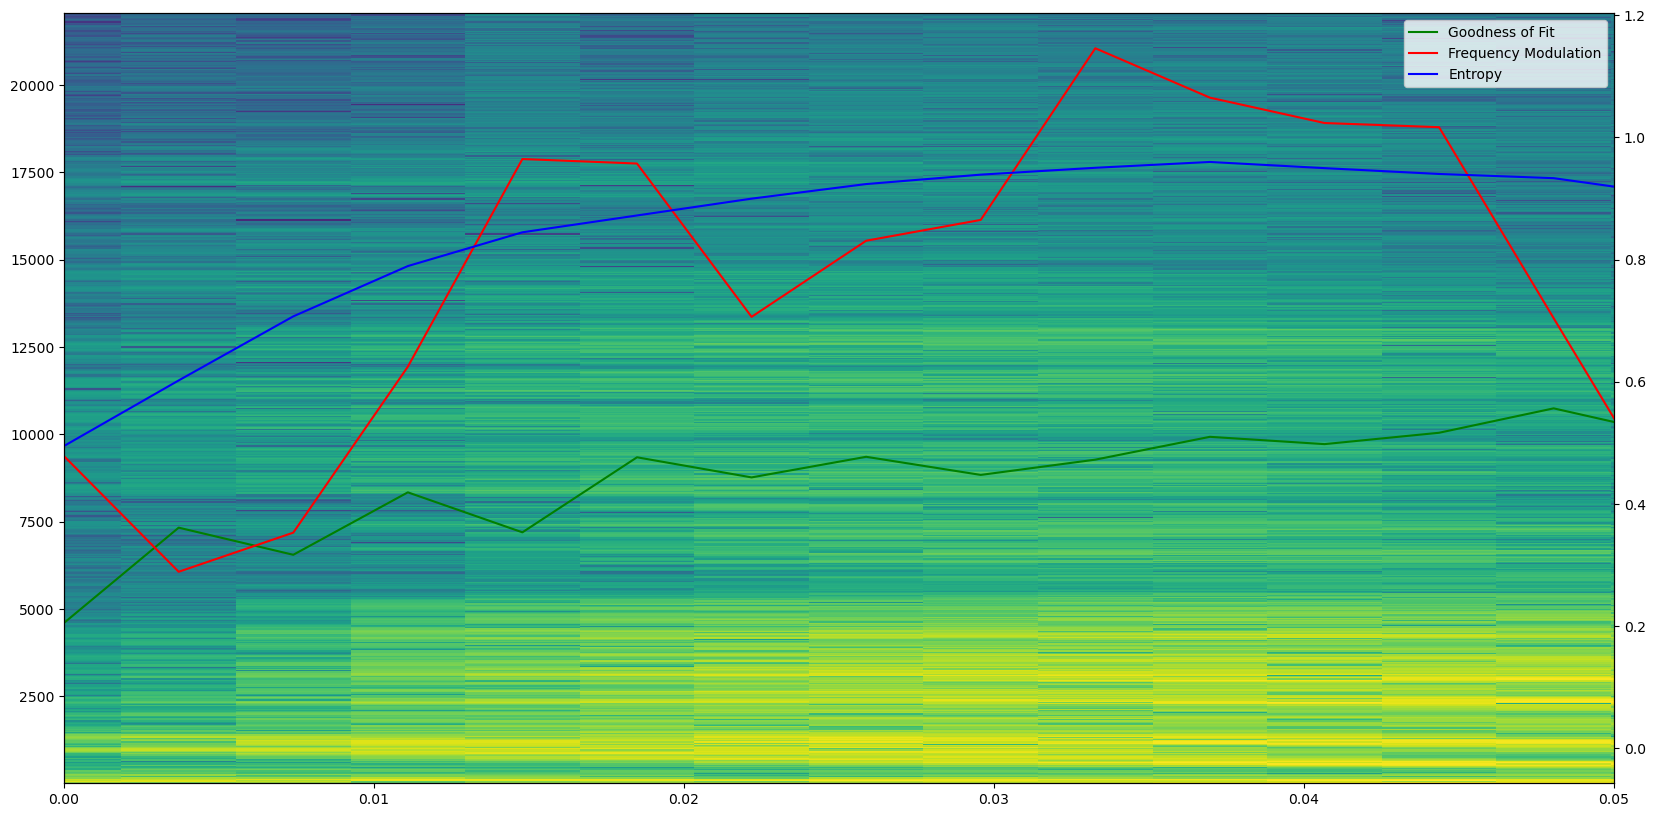

<Figure size 640x480 with 0 Axes>

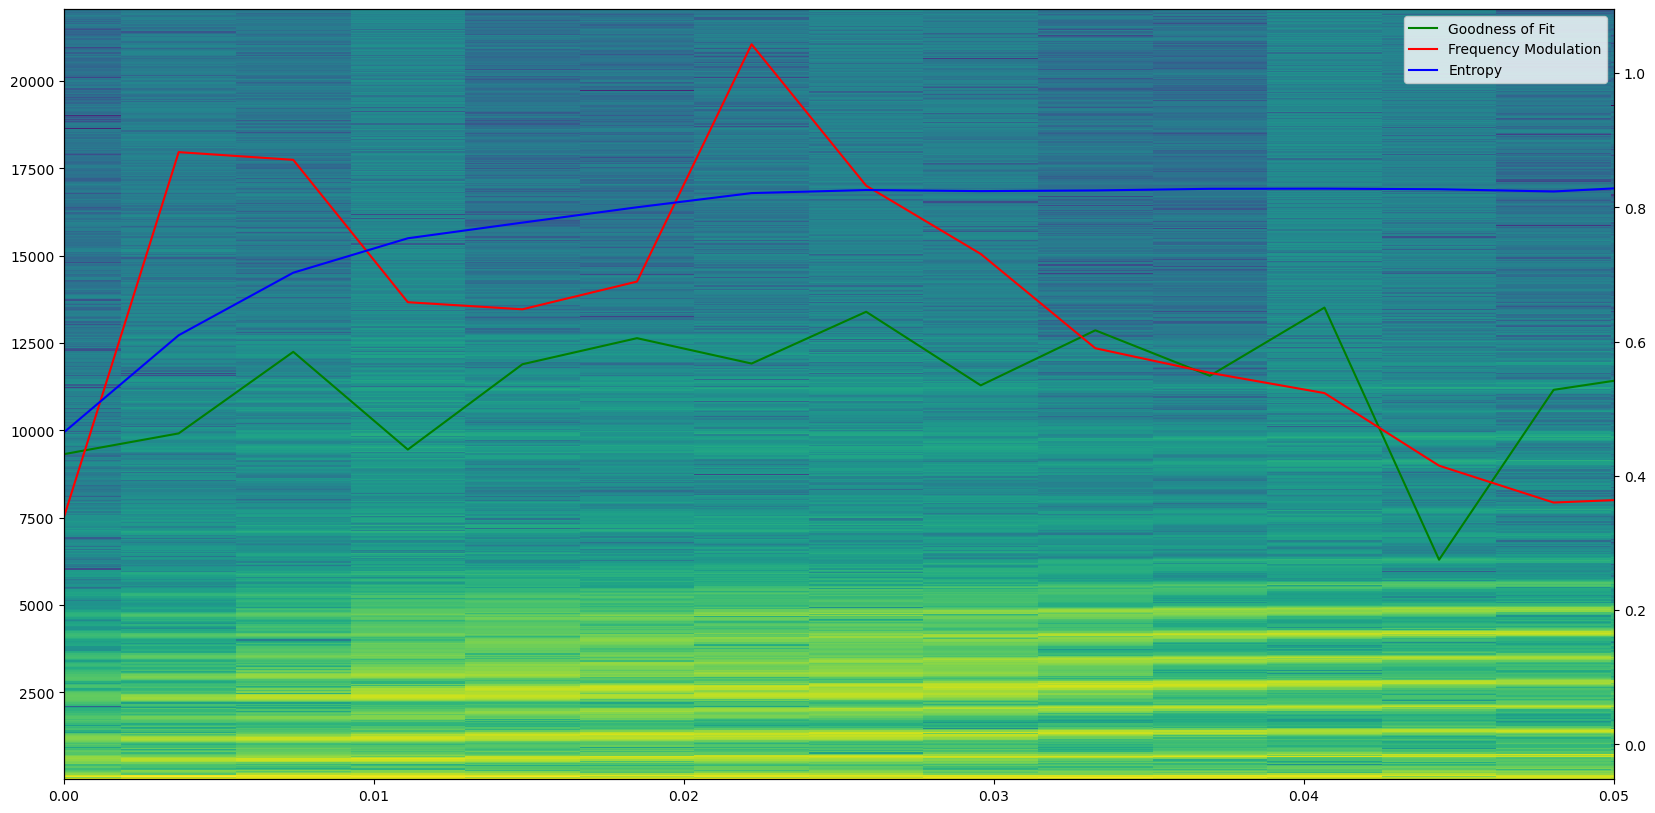

In [9]:
def plot_syllables(syllables, index):
    fig, ax1 = plt.subplots(figsize=(20,10))
    plt.pcolormesh(syllables['t'][index], syllables['f'][index], np.log10(syllables['sd'][index]))
    ax2 = ax1.twinx()
    ax2.plot(syllables['t'][index], syllables['gof'][index], 'g', label='Goodness of Fit')
    ax2.plot(syllables['t'][index], syllables['fm'][index], 'r', label='Frequency Modulation')
    ax2.plot(syllables['t'][index], syllables['ent'][index], 'b', label='Entropy')
    plt.legend()
    plt.xlim([0, 0.05])

plt.figure()
plot_syllables(syllables, 0)
plt.figure()
plot_syllables(syllables, 2)

In [10]:
# Get minimum syllable length
min_window = 14

# For each syllable, stack all of the features into a matrix
def syllable_feature_matrix(syllables, index):
    sg = syllables['Sxx'][index]
    sd = np.log10(syllables['sd'][index])
    ent = syllables['ent'][index]
    gof = syllables['gof'][index]
    fm = syllables['fm'][index]
    amp = syllables['amp'][index]

    # Stack the features into a matrix
    feature_matrix = np.vstack((sd, ent, gof, fm, amp)).T
    return feature_matrix[:min_window,:]

feature_shape = syllable_feature_matrix(syllables, i).flatten()

# Get the feature matrix for the first syllable
feature_matrix = np.zeros((syllables.shape[0], feature_shape.shape[0]))
for i in range(syllables.shape[0]):
    feature_matrix[i] = syllable_feature_matrix(syllables, i).flatten()

# Replace all nan valuees with 0
feature_matrix = np.nan_to_num(feature_matrix,  posinf=33333333, neginf=-33333333)

C:\Users\nriveira\AppData\Local\Temp\ipykernel_22892\2317022561.py:7: RuntimeWarning: divide by zero encountered in log10
  sd = np.log10(syllables['sd'][index])


In [11]:
import umap
import sklearn.cluster as cluster
import hdbscan

c:\Users\nriveira\Miniconda3\envs\birdsong\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\nriveira\Miniconda3\envs\birdsong\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


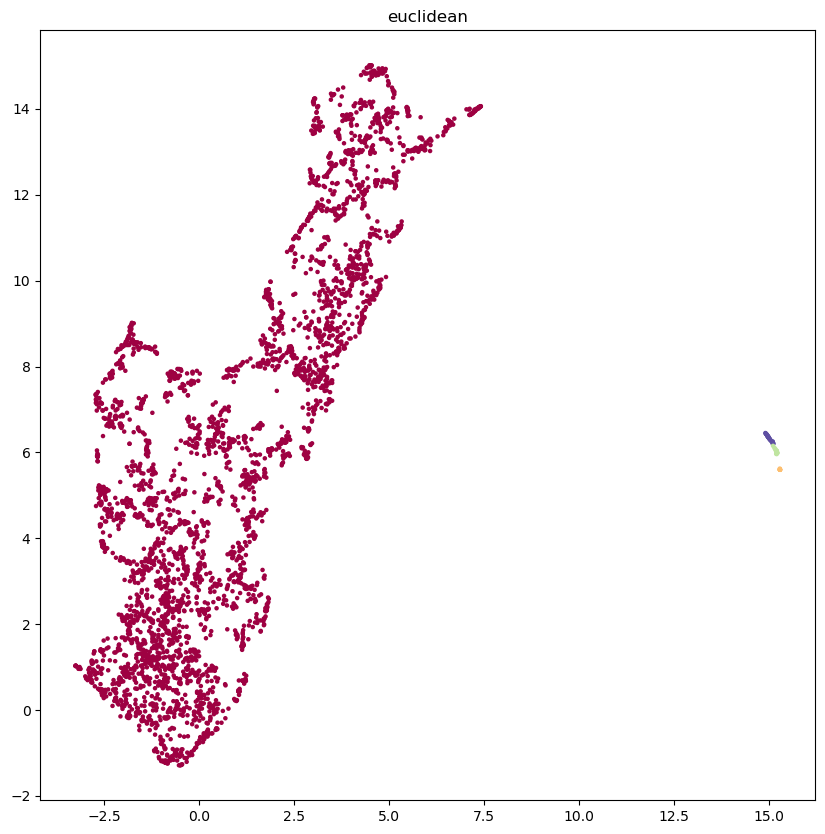

c:\Users\nriveira\Miniconda3\envs\birdsong\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


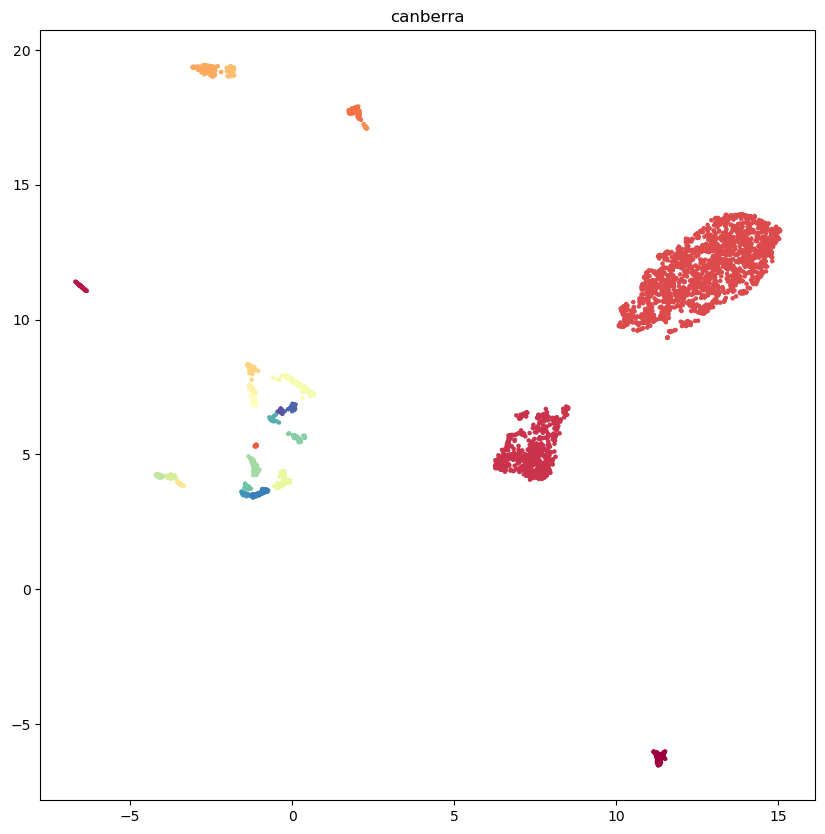

c:\Users\nriveira\Miniconda3\envs\birdsong\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


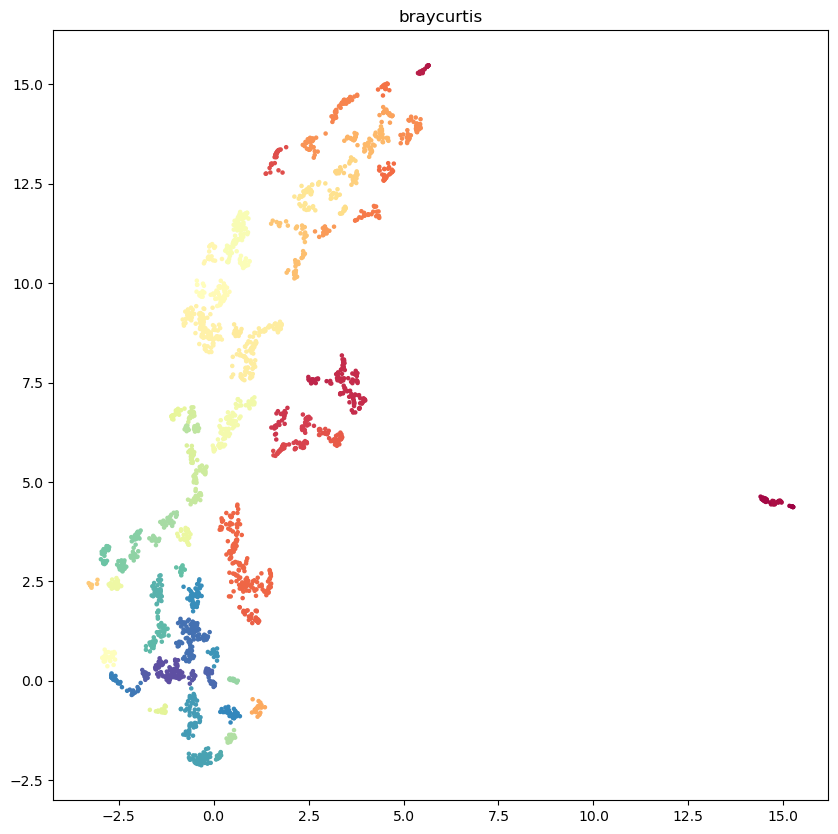

c:\Users\nriveira\Miniconda3\envs\birdsong\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


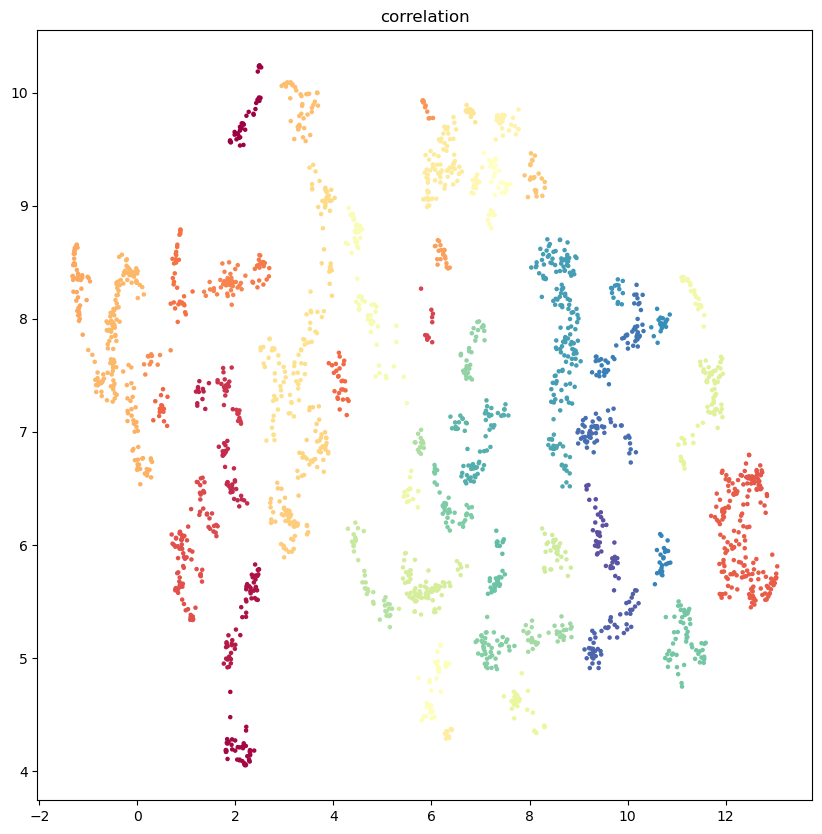

In [13]:
nc = 2
nn = 10
md = 0.0
dist_mets = ['euclidean','canberra','braycurtis', 'correlation']
for dm in dist_mets:
    clusterable_embedding = umap.UMAP(
        n_neighbors=nn,
        min_dist=md,
        n_components=nc,
        metric=dm,
        random_state=69,
    ).fit_transform(feature_matrix)

    labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=10).fit_predict(clusterable_embedding)

    plt.figure(figsize=(10,10))
    clustered = (labels >= 0)
    plt.scatter(clusterable_embedding[clustered, 0],
                clusterable_embedding[clustered, 1],
                c=labels[clustered],
                s=5,
                cmap='Spectral')
    plt.title(dm)
    plt.show()

In [ ]:
nc = 2
md = 0.1
dm = 'canberra'
n_neighbors = [2, 5, 10, 20, 50, 100, 200]

for nn in n_neighbors:
    clusterable_embedding = umap.UMAP(
        n_neighbors=nn,
        min_dist=md,
        n_components=nc,
        metric=dm,
        random_state=69,
    ).fit_transform(feature_matrix)

    labels = hdbscan.HDBSCAN(min_samples=50, min_cluster_size=10).fit_predict(clusterable_embedding)

    plt.figure(figsize=(10,10))
    clustered = (labels >= 0)
    plt.scatter(clusterable_embedding[clustered, 0],
                clusterable_embedding[clustered, 1],
                c=labels[clustered],
                s=5,
                cmap='Spectral')

In [ ]:
nc = 2
nn = 5
dm = 'canberra'
min_dist = [0.01, 0.1, 0.25, 0.5, 0.8, 0.99]

for md in min_dist:
    clusterable_embedding = umap.UMAP(
        n_neighbors=nn,
        min_dist=md,
        n_components=nc,
        metric=dm,
        random_state=69,
    ).fit_transform(feature_matrix)

    labels = hdbscan.HDBSCAN(min_samples=50, min_cluster_size=10).fit_predict(clusterable_embedding)

    plt.figure(figsize=(10,10))
    clustered = (labels >= 0)
    plt.scatter(clusterable_embedding[clustered, 0],
                clusterable_embedding[clustered, 1],
                c=labels[clustered],
                s=5,
                cmap='Spectral')

In [ ]:
clusterable_embedding = umap.UMAP(
        n_neighbors=5,
        min_dist=0.25,
        n_components=2,
        metric='canberra',
        random_state=69,
    ).fit_transform(feature_matrix)

labels = hdbscan.HDBSCAN(min_samples=30, min_cluster_size=10).fit_predict(clusterable_embedding)

plt.figure(figsize=(10,10))
clustered = (labels >= 0)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=5,
            cmap='Spectral')

plt.colorbar()

In [ ]:
i = 7
# Find all of the syllable indices
syllable_indices = np.where(labels == i)[0]

concat = []
# Concatenate all of the syllables together
for i in syllable_indices:
#     cs_index = []
    concat.append(syllables['audio'][i])
#     for k in range(i, len(syllable_indices)):
#         cs_index.append(librosa.segment.cross_similarity(syllables['audio'][i], syllables['audio'][k], metric='canberra').sum())
#     print(np.mean(cs_index))
            

# Play in notebook
ipd.Audio(np.array(concat).flatten(), rate=fs)

In [ ]:
x = librosa.segment.cross_similarity(syllables['audio'][0], syllables['audio'][1], metric='canberra')